In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

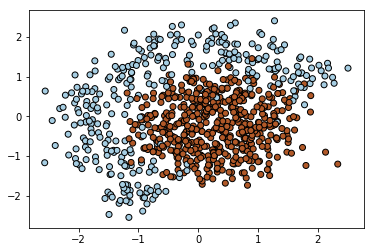

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    with tf.Session() as sess:
        Z = sess.run(classify(np.c_[xx.ravel(), yy.ravel()], w))
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
num_features = 6
def compute_raw_predictions(X, w):
    """Given expanded feature matrix [n_samples, 6] and weight vector w[6],
    compute dot product of each element with weight.
    """
    return tf.reshape(tf.matmul(X, tf.reshape(w, (-1, 1))), (-1,))

In [5]:
def expand(X):
    X_ = tf.zeros((X.shape[0], 6))
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(X.shape[0], 1), dtype=tf.float64)], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    expanded_x = expand(X)
    raw_scores = compute_raw_predictions(expanded_x, w)
    num_samples = tf.shape(X)[0]
    raw_scores = tf.reshape(raw_scores, [num_samples])
    minus_ones = tf.fill([num_samples], -1, name='minus_ones')
    ones = tf.fill([num_samples], 1, name='ones')
    return tf.where(tf.less(raw_scores, 0), minus_ones, ones)

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [6]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    X = expand(X)
    maxed_values = 1 - y * compute_raw_predictions(X, w)
    maximums = tf.maximum(tf.constant(0, dtype=tf.float64), maxed_values)
    summed = tf.reduce_sum(maximums)
    divisor = tf.cast(tf.shape(X)[0], dtype=tf.float64)
    return summed / divisor
    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    # dL/dw_1 = 1/N * sum(f(-x_{i,1}*y_i))
    partial_derivatives = []
    X = expand(X)
    maxed_values = 1 - y * compute_raw_predictions(X, w)
    divisor = tf.cast(tf.shape(X)[0], dtype=tf.float64)

    
    for feature_idx in range(num_features):
        current_values = tf.where(tf.less(maxed_values, 0), 
                                  tf.zeros([tf.shape(X)[0]], dtype=tf.float64), 
                                  -1 * X[:, feature_idx] * y)
        cur_derivative = tf.reduce_sum(current_values) / divisor
        partial_derivatives.append(cur_derivative)
    
    return tf.stack(partial_derivatives)

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

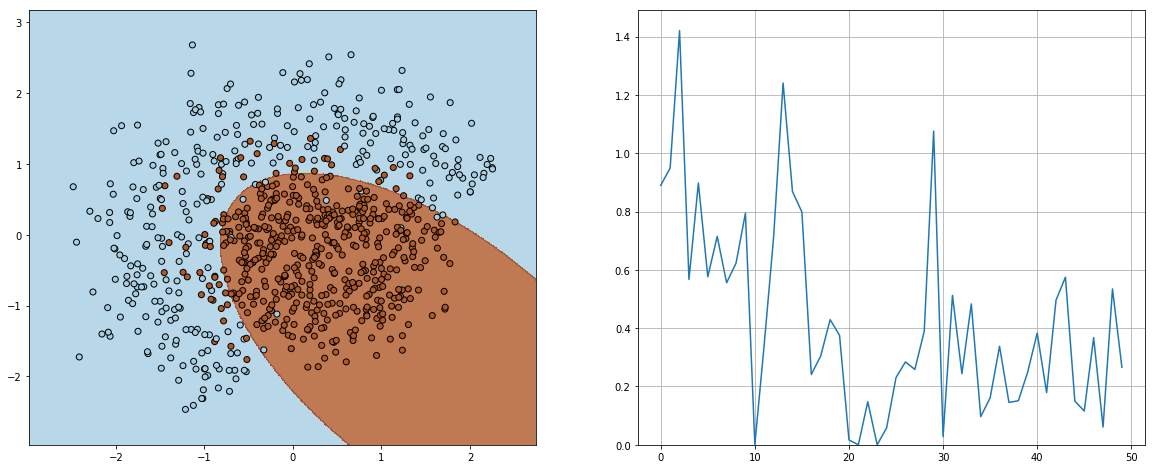

In [7]:
n_iter = 50
batch_size = 4

w = np.array([1,0,0,0,0,0], dtype=np.float64)

alpha = 0.1 # learning rate



loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        x_batch = X[ind,:]
        y_batch = y[ind]
        
        loss[i] = sess.run(compute_loss(x_batch, y_batch, w))
        #visualize(x_batch, y_batch, w, loss, n_iter)

        gradient = alpha * compute_grad(x_batch, y_batch, w)
        optimizer = w - gradient
        w = sess.run(optimizer)
        
        print('Iteration {}'.format(i))
        print('w = {}'.format(w))
        print('loss = {}\n'.format(loss[i]))

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

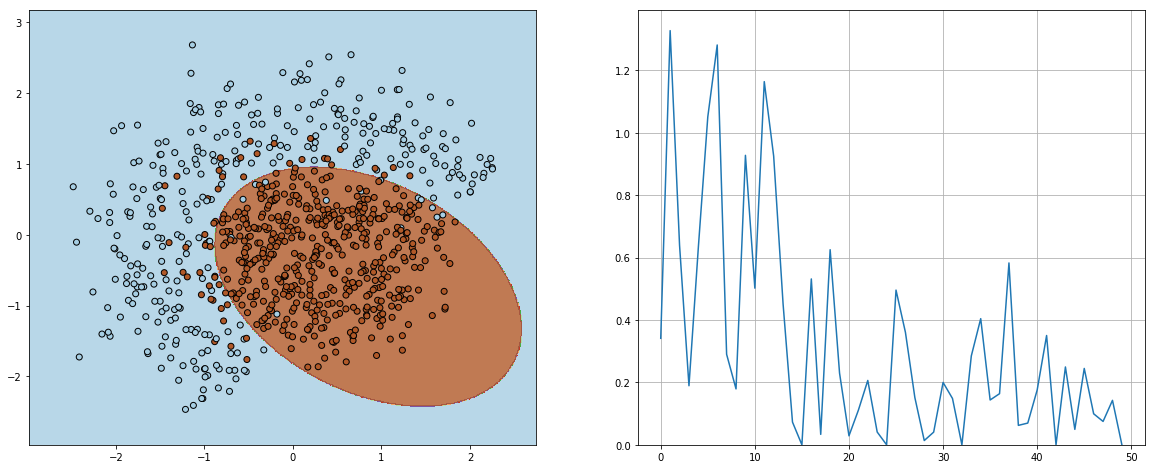

In [8]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)
momentum = np.array([0,0,0,0,0,0], dtype=np.float64)

alpha = 0.1 # learning rate
mu    = 0.7 # momentum

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        x_batch = X[ind,:]
        y_batch = y[ind]
        
        loss[i] = sess.run(compute_loss(x_batch, y_batch, w))
        #visualize(x_batch, y_batch, w, loss, n_iter)

        gradient = compute_grad(x_batch, y_batch, w)
        momentum = mu * momentum - alpha * gradient
        optimizer = w + momentum
        w = sess.run(optimizer)
        
        print('Iteration {}'.format(i))
        print('w = {}'.format(w))
        print('loss = {}\n'.format(loss[i]))
        
visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

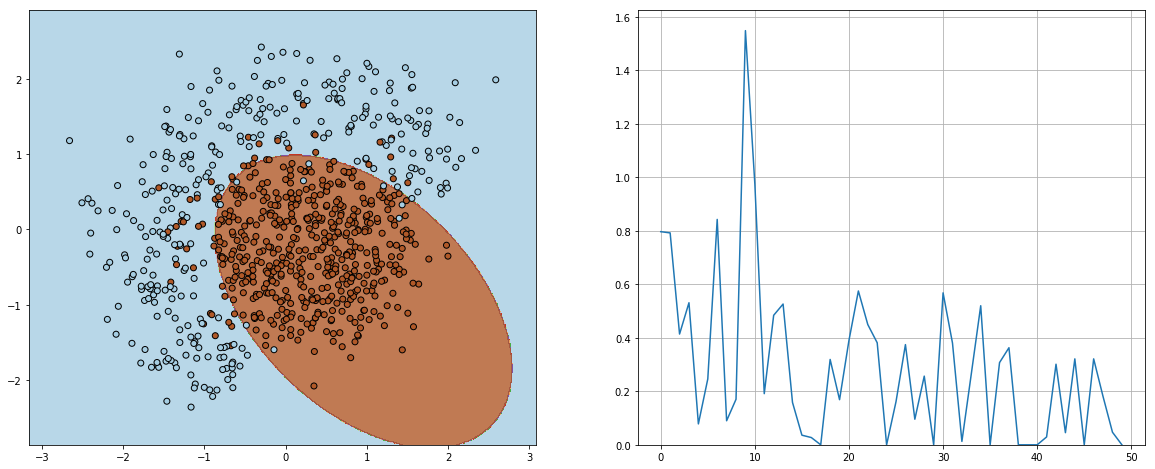

In [7]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)
momentum = np.array([0,0,0,0,0,0], dtype=np.float64)

alpha = 0.1 # learning rate
mu    = 0.7 # momentum

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        x_batch = X[ind,:]
        y_batch = y[ind]
        
        loss[i] = sess.run(compute_loss(x_batch, y_batch, w))

        # https://stats.stackexchange.com/a/184284
        gradient = compute_grad(x_batch, y_batch, w + mu * momentum)
        momentum = sess.run(mu * momentum - alpha * gradient)
        
        w = w + momentum
        
        print('Iteration {}'.format(i))
        print('w = {}'.format(w))
        print('loss = {}\n'.format(loss[i]))

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaGrad:

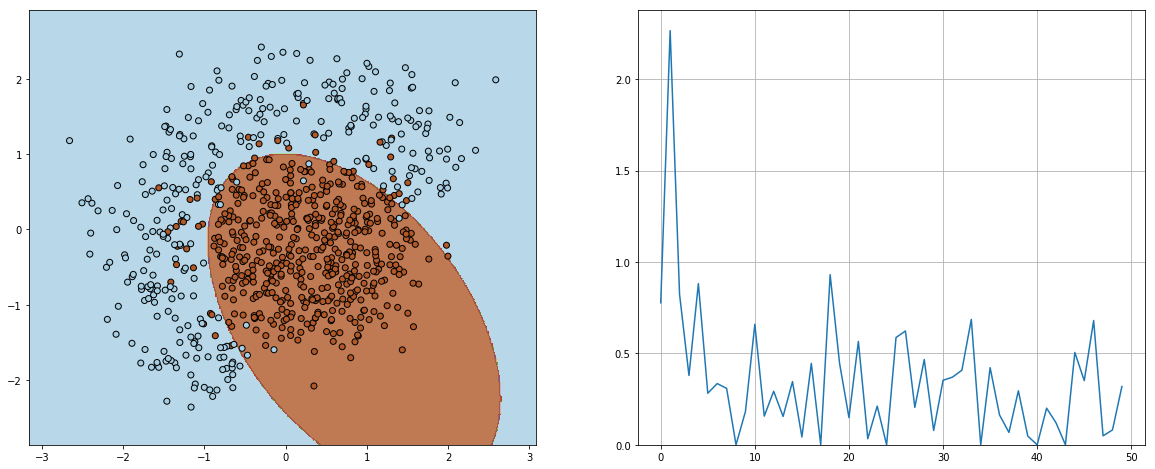

In [15]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)
cache_dist = 0

alpha = 0.7 # learning rate
eps = 1e-8  # A small constant for numerical stability

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        x_batch = X[ind,:]
        y_batch = y[ind]
        
        loss[i] = sess.run(compute_loss(x_batch, y_batch, w))

        gradient = compute_grad(x_batch, y_batch, w)
        cache_upd = tf.norm(gradient, ord=2)
        
        cache_dist += sess.run(cache_upd)
        
        w = sess.run(w - alpha / (tf.sqrt(cache_dist) + eps) * gradient)
        
        print('Iteration {}'.format(i))
        print('w = {}'.format(w))
        print('loss = {}\n'.format(loss[i]))

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaDelta:

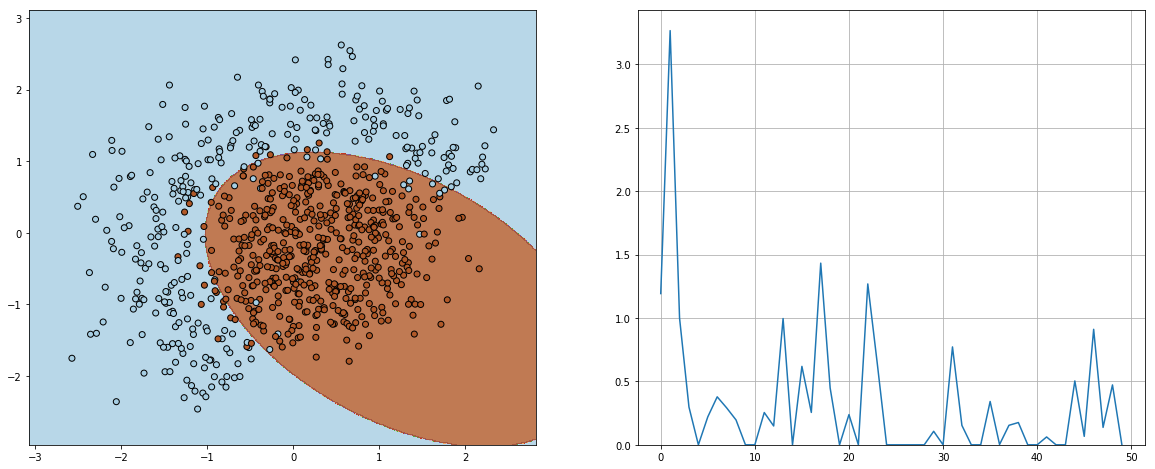

In [9]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)
cache_dist = 0

alpha = 0.7 # learning rate
beta = 0.9
eps = 1e-8  # A small constant for numerical stability

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        x_batch = X[ind,:]
        y_batch = y[ind]
        
        loss[i] = sess.run(compute_loss(x_batch, y_batch, w))

        gradient = compute_grad(x_batch, y_batch, w)
        cache_upd = (1 - beta) * tf.norm(gradient, ord=2)
        
        cache_dist = cache_dist * beta + sess.run(cache_upd)
        
        w = sess.run(w - alpha / (tf.sqrt(cache_dist) + eps) * gradient)
        
        print('Iteration {}'.format(i))
        print('w = {}'.format(w))
        print('loss = {}\n'.format(loss[i]))

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

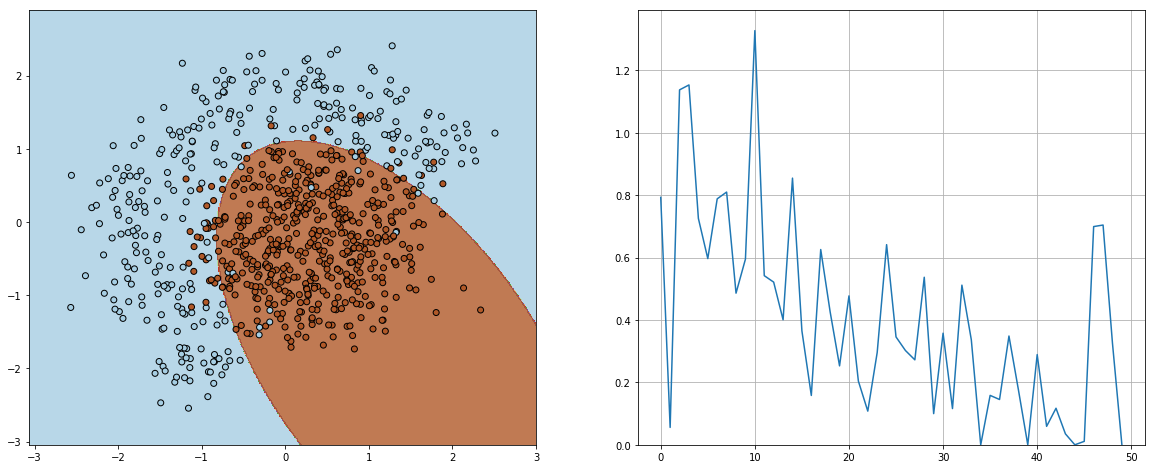

In [11]:
w = np.array([1,0,0,0,0,0], dtype=np.float64)
momentum = np.array([0,0,0,0,0,0], dtype=np.float64)
cache_dist = 0

alpha = 0.1# learning rate
beta = 0.7  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.5  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        x_batch = X[ind,:]
        y_batch = y[ind]
        
        loss[i] = sess.run(compute_loss(x_batch, y_batch, w))

        gradient = compute_grad(x_batch, y_batch, w)
        cache_upd = (1 - beta) * tf.norm(gradient, ord=2)
        
        momentum = sess.run(mu * momentum + (1 - mu) * gradient)
        cache_dist = cache_dist * beta + sess.run(cache_upd)
        
        w = sess.run(w - alpha / (tf.sqrt(cache_dist) + eps) * momentum)
        
        print('Iteration {}'.format(i))
        print('w = {}'.format(w))
        print('loss = {}\n'.format(loss[i]))
visualize(X, y, w, loss, n_iter)
plt.clf()